Import all used packages

In [1]:
# For displaying images
from IPython.display import Image

# For plotting figures
import matplotlib.pyplot as plt
from matplotlib import gridspec

# For array and matrix data structures
import numpy as np

# For data manipulation and analysis
import pandas as pd

# For the confusion matrix
import seaborn as sns3
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# For computing the neural network and preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
# from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import RandomFlip, RandomContrast, RandomTranslation
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16


# Set Matplotlib defaults such that plots are bigger and labels are more clear
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
      titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

Loading the data

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_dir = "/content/drive/MyDrive/clean_cropped_dataset/train"
valid_dir = "/content/drive/MyDrive/clean_cropped_dataset/validation"
test_dir = "/content/drive/MyDrive/clean_cropped_dataset/test"
# Load in the training data
ds_train = image_dataset_from_directory(
    train_dir,
    labels='inferred',         # same labels as map labels
    label_mode='categorical',  # categorical data
    image_size=[224, 224],
    interpolation='nearest',   # used for small image size
    batch_size=32,
    shuffle=True,              # classes are randomized
)
class_names = ds_train.class_names
print(class_names)
# Load in the validation data
ds_valid = image_dataset_from_directory(
    valid_dir,
    labels='inferred',         # same labels as map labels
    label_mode='categorical',  # categorical data
    image_size=[224, 224],
    interpolation='nearest',   # used for small image size
    batch_size=32,
    shuffle=True,              # classes are randomized
)

# Load in the test data
ds_test = image_dataset_from_directory(
    test_dir,
    labels='inferred',         # same labels as map labels
    label_mode='categorical',  # categorical data
    image_size=[224, 224],
    interpolation='nearest',   # used for small image size
    batch_size=32,
    shuffle=True,              # classes are randomized
)

Found 1897 files belonging to 13 classes.
['bb', 'bk', 'bn', 'bp', 'bq', 'br', 'empty', 'wb', 'wk', 'wn', 'wp', 'wq', 'wr']
Found 232 files belonging to 13 classes.
Found 229 files belonging to 13 classes.


In [3]:
# Converting tf.uint8 to type float to normalize the images
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label
AUTOTUNE = tf.data.experimental.AUTOTUNE

# normalize images from the training data
ds_train = (
    ds_train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# normalize images from the validation data
ds_valid = (
    ds_valid
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# normalize images from the test data
ds_test = (
    ds_test
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

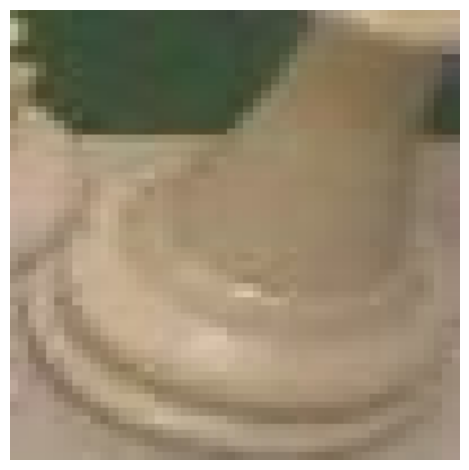

Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [4]:
for images, labels in ds_train.take(1):  # Take one batch
    first_image = images[0].numpy().astype("float32")  # Convert tensor to numpy
    first_label = labels[0]  # Extract the first label
    break
# Plot the first image
plt.imshow(first_image)
plt.axis("off")  # Hide axes
plt.show()

# Print the label (optional)
print("Label:", first_label.numpy())

In [5]:
import tensorflow as tf
import numpy as np

# Assuming ds_train, ds_valid, and ds_test are defined as in the provided code

# Get the shape of the first batch in the training dataset
for images, labels in ds_train.take(1):
    train_shape = images.shape
    break
print("Training dataset shape (first batch):", train_shape)

# Get the shape of the first batch in the validation dataset
for images, labels in ds_valid.take(1):
    valid_shape = images.shape
    break
print("Validation dataset shape (first batch):", valid_shape)

# Get the shape of the first batch in the test dataset
for images, labels in ds_test.take(1):
    test_shape = images.shape
    break
print("Test dataset shape (first batch):", test_shape)

Training dataset shape (first batch): (32, 224, 224, 3)
Validation dataset shape (first batch): (32, 224, 224, 3)
Test dataset shape (first batch): (32, 224, 224, 3)


In [6]:
model = models.Sequential(
    [
        RandomContrast(factor=0.5), # lighter/darker colors
        RandomFlip(mode='horizontal'), # left-to-right
        RandomTranslation(height_factor=0.1, width_factor=0.1) # height decreased
    ]
)
model.add(layers.Conv2D(32, (7, 7), activation='relu', input_shape=(224, 224, 3),padding='same')) # 218 * 218 * 32
model.add(layers.MaxPooling2D((2, 2))) # 109 * 109 * 32
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same')) # 107 * 107 * 64
model.add(layers.MaxPooling2D((2, 2))) # 54 * 54 * 64
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same')) # 52 * 52 * 64
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_contrast (RandomContrast)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ ?                           │     0 (unbuilt) │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])



In [ ]:
history = model.fit(ds_train, epochs=60,
                    validation_data=ds_valid)

Epoch 1/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 288s 5s/step - accuracy: 0.1074 - loss: 3.6002 - val_accuracy: 0.2026 - val_loss: 2.2364
Epoch 2/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.2030 - loss: 2.1263 - val_accuracy: 0.1422 - val_loss: 2.2109
Epoch 3/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.2015 - loss: 1.9843 - val_accuracy: 0.2198 - val_loss: 1.9508
Epoch 4/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.2377 - loss: 1.8812 - val_accuracy: 0.2371 - val_loss: 1.9102
Epoch 5/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.2771 - loss: 1.8492 - val_accuracy: 0.2198 - val_loss: 1.8952
Epoch 6/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.2956 - loss: 1.8127 - val_accuracy: 0.2845 - val_loss: 1.8514
Epoch 7/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.2701 - loss: 1.8034 - val_accuracy: 0.2802 - val_loss: 1.8579
Epoch 8/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.2958 - loss: 1.7702 - val_accuracy: 0.2888 - v

8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.5817 - loss: 1.1446
Test Loss: 1.2032, Test Accuracy: 0.5677
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


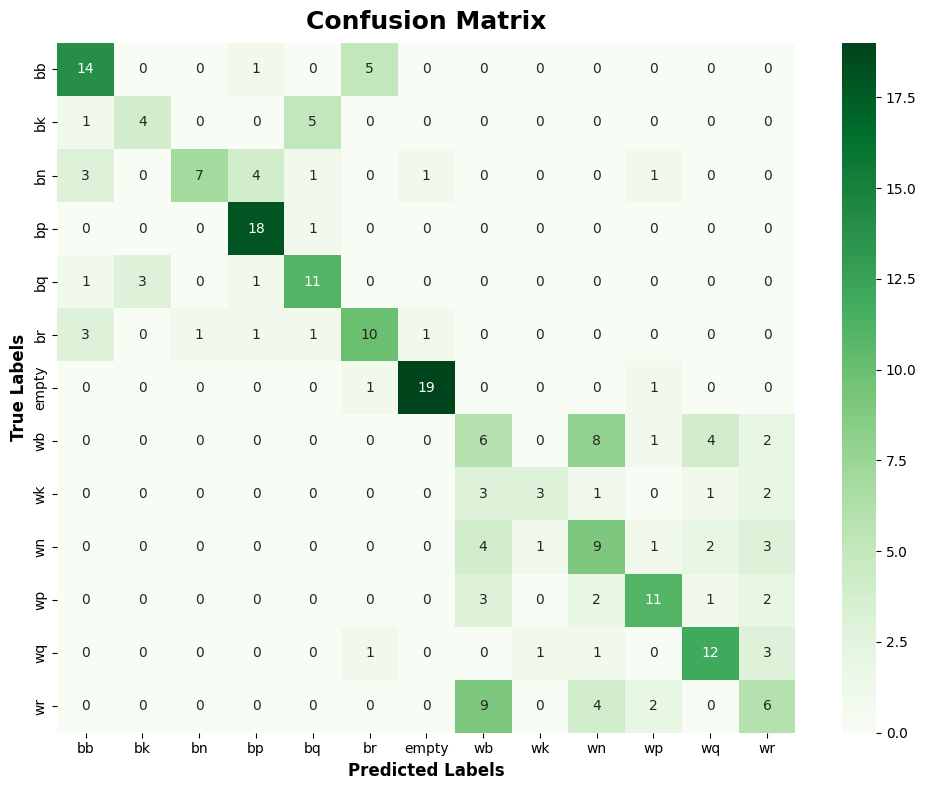


Classification Report:
              precision    recall  f1-score   support

          bb       0.64      0.70      0.67        20
          bk       0.57      0.40      0.47        10
          bn       0.88      0.41      0.56        17
          bp       0.72      0.95      0.82        19
          bq       0.58      0.69      0.63        16
          br       0.59      0.59      0.59        17
       empty       0.90      0.90      0.90        21
          wb       0.24      0.29      0.26        21
          wk       0.60      0.30      0.40        10
          wn       0.36      0.45      0.40        20
          wp       0.65      0.58      0.61        19
          wq       0.60      0.67      0.63        18
          wr       0.33      0.29      0.31        21

    accuracy                           0.57       229
   macro avg       0.59      0.55      0.56       229
weighted avg       0.58      0.57      0.56       229

Overall Accuracy: 0.5677


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- Evaluation on Test Set ---
test_loss, test_accuracy = model.evaluate(ds_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# --- Predictions for Confusion Matrix and Classification Report ---
# Get predictions on the test dataset
predicted_probabilities = model.predict(ds_test)
predicted_labels = np.argmax(predicted_probabilities, axis=1) # Get class indices from probabilities

# Get true labels from the test dataset
all_true_labels = []
for images, labels in ds_test: # Corrected loop to unpack images and labels
    all_true_labels.extend(np.argmax(labels.numpy(), axis=1)) # Assuming labels are one-hot encoded
all_true_labels = np.array(all_true_labels)

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(all_true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names) # Use class_names here (defined from ds_train)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# --- Classification Report ---
class_report = classification_report(all_true_labels, predicted_labels, target_names=class_names) # Use class_names here (defined from ds_train)
print("\nClassification Report:")
print(class_report)

# --- Overall Accuracy ---
overall_accuracy = accuracy_score(all_true_labels, predicted_labels)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

In [10]:
# prompt: save model to file

model.save('saved_model.h5')


In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns  # Import seaborn for visualization
import tensorflow as tf  # Import tensorflow
import cv2  # Import OpenCV


# Load the saved model
try:
    model = keras.models.load_model('/content/saved_model.h5')
    print("Model loaded successfully!")
except OSError as e:
    print(f"Error: The model file '/content/saved_model.h5' could not be opened. It might be corrupted or not a valid H5 file. Check the file and its integrity.  Error details: {e}")
    exit()  # Exit the script if the model can't be loaded
except FileNotFoundError:
    print(f"Error: The model file '/content/saved_model.h5' was not found.  Make sure the file exists at that path.")
    exit()  # Exit if the model can't be loaded
except Exception as e:
    print(f"An unexpected error occurred while loading the model: {e}")
    exit()  # Exit the script if the model can't be loaded

# Make predictions on a single test image
try:
    test_image_path = '/content/drive/MyDrive/clean_cropped_dataset/test/bb/alpha_data_image10304.jpeg'

    # Load and preprocess the image using OpenCV (or PIL, if you prefer)
    img = cv2.imread(test_image_path)
    if img is None:
        raise ValueError(f"Could not read image at {test_image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Resize the image to match the input size of your model (VERY IMPORTANT!)
    img = cv2.resize(img, (224, 224))  # Assuming your model expects 224x224 images - MODIFY AS NEEDED

    # Convert the image to a numpy array and normalize
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1] - MODIFY AS NEEDED

    # Add a batch dimension (models expect a batch of images)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction
    y_pred = model.predict(img_array)
    predicted_class = np.argmax(y_pred, axis=1)

    print("Predicted class index:", predicted_class[0]) # print the class index

    # If you have class names, you can map the index to the name
    class_names = ['bb', 'bk', 'bn', 'bp', 'bq', 'br', 'empty', 'wb', 'wk', 'wn', 'wp', 'wq', 'wr']
    print("Predicted class:", class_names[predicted_class[0]])

except Exception as e:
    print(f"Error during prediction: {e}")
    exit()

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Predicted class index: 0
Predicted class: bb
